In [3]:
#2022-03-09 12:42:28 
import os
import pandas as pd 
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from matplotlib import font_manager
# Add every font at the specified location
font_dir = ['/home/UTHSCSA/hef/Tools/miniconda3/fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
# Set font family globally
mpl.rcParams['font.family'] = 'Arial'

import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages

from datetime import datetime
time = datetime.now().strftime("%Y_%m_%d")

import adjustText
from adjustText import adjust_text

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
outdir = '/home/UTHSCSA/hef/2.Project/5.PDX/3.plot/5.CNV_ploidy_purity'

In [5]:
a,b,c,d,e,f,g,h,i = [plt.cm.winter, plt.cm.cool, plt.cm.spring, plt.cm.copper, plt.cm.bone, plt.cm.gist_heat, plt.cm.pink, plt.cm.summer, plt.cm.autumn]

cancer_ranking_all = [ 'Osteosarcoma', 'Clear Cell Sarcoma', 'Other Sarcoma',   'Wilms Tumor', 'Hepatoblastoma','Germ Cell Tumor',   'Neuroblastoma', 'Other Tumor']
color_ranking_all = ['brg', 'Oranges', 'Reds', 'Greens_r', 'Purples_r', 'Blues_r',  'nipy_spectral', 'Greys_r']

color_ranking_palette = [ f(.6), f(.8), f(.3), h(.6), b(.6), a(.6), h(.2), e(.6)]
color_ranking_dict = {'Osteosarcoma':  f(.6),  'Clear Cell Sarcoma':f(.8), 'Other Sarcoma':f(.3),  'Wilms Tumor': h(.6), 'Hepatoblastoma':b(.6),
                     'Germ Cell Tumor': a(.6),   'Neuroblastoma':h(.2), 'Other Tumor': e(.6)}


cancer_ranking_all2 = [ 'Ovarian tumor', 'Wilms Tumor', 'Ewing Sarcoma', 'Mesothelioma', 'Clear Cell Sarcoma', 'Hepatoblastoma', 'Neuroblastoma',
                        'Germ Cell Tumor', 'Pleomorphic Sarcoma', 'Adrenal cortical carcinoma', 'Osteosarcoma', 'ERMS', 'Glioblastoma']
color_ranking_palette2 = ['darkred',h(.6), 'red', 'gold', f(.3), b(.6), h(.2),a(.6), 'firebrick', 'hotpink', f(.6), f(.7), 'darkviolet']


In [10]:
data = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/Final_purity_ploidy.seqz_pureCN.txt', sep = '\t')
data = data.set_index(['Disease Code level 1']).T[[i for i in cancer_ranking_all if i in list(data['Disease Code level 1']) ]].T.reset_index()
paired_idx = list(data[data['PT_Ploidy'].notna() & data['PDX_Ploidy'].notna() ]['PatientID'])

## DEF

In [11]:
## add cancer info
cancer = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/master_table.v5.txt')
cancer = cancer[['ID','Final Diagnosis (Laura)','Disease Code level 2', 'Disease Code level 1', 'Tumor Collected (Primary or Met)','Gender','Age(year)','Therapy prior to PDX collection']]
def add_cancer_info(data, column):
    k = []
    for ids in list(data[column]):
        if str(ids) in list(cancer['ID']):
            
            k.append(list(cancer[cancer['ID'] == str(ids)].iloc[0]))
            #print( list(cancer[cancer['ID'] == str(ids)].iloc[0]))
        else:
            #print(str(ids))
            k.append(['NA'] * 8)
    data[['PDXID','Tumor Class','Disease Code level 2', 'Disease Code level 1', 'Primary or Met','Gender','Age(year)','Therapy prior to PDX collection'] ]= pd.DataFrame(k)
    #print(pd.DataFrame(k))
    return data


In [144]:
def plot_box_with_ax_datatype(dt, X, Y, ax):
    cancer_ranking1 = dt.groupby(X).median().sort_values(Y, ascending=False).index
    color_ranking1 = [color_ranking_palette[cancer_ranking_all.index(i)]  for i in cancer_ranking1 ]


    p = sns.boxplot(data = dt, x = X, y = Y,  order = cancer_ranking1,  palette=color_ranking1, ax = ax,
            fliersize=0,
                boxprops={'edgecolor': 'black', 'alpha':1,'linewidth':0, },  
                medianprops={'color':'black', 'alpha':1, 'linewidth':1.5},
                whiskerprops={'linewidth':1, 'color':'black','alpha' : 1},
           )
    plt.setp(p.collections, alpha=.7, linewidth=0)

    p = sns.stripplot(data = dt[dt['Datatype'] == 'PT'], x = X, y = Y,  ax =ax,
              color='steelblue', marker = 'o', size = 9, alpha = 0.9,  linewidth=0.5, edgecolor = '.2', jitter = 0.2,
             order =cancer_ranking1)
    p = sns.stripplot(data = dt[dt['Datatype'] == 'PDX'],  x = X, y = Y,  ax = ax,
              color='orange', marker = '^', size = 9, alpha = 0.9, linewidth=0.5, edgecolor = '.2', jitter=0.2,
             order =cancer_ranking1)
    
    p.set_xticklabels(cancer_ranking1, rotation = 90)
    p.set_xlabel('')
    sns.despine()
    p.legend(bbox_to_anchor = (1,1), frameon=False)

## ploidy

In [12]:
cancer_ranking = [i for i in cancer_ranking_all if i in list(data['Disease Code level 1']) ]
color_ranking = [color_ranking_all[cancer_ranking_all.index(i)]  for i in cancer_ranking ]

In [29]:
dk = data[['PatientID', 'Disease Code level 1',  'Disease Code level 2', 'PT_Ploidy', 'PDX_Ploidy']]
dk = dk.melt(id_vars=['PatientID', 'Disease Code level 1',  'Disease Code level 2'], value_name='Ploidy', var_name='Datatype').replace('_Ploidy', '', regex = True).dropna(axis = 0)
dk['ID'] = dk['PatientID'] +'_'+ dk['Datatype']
dk = dk.sort_values(['Ploidy','ID','Datatype'])

In [16]:
dm = dk

In [17]:
cancer_ranking = list(dm.groupby('Disease Code level 1').median().sort_values('Ploidy', ascending=False).index)
color_ranking = [color_ranking_palette[cancer_ranking_all.index(i)]  for i in cancer_ranking ]

In [18]:
wgd_freq =  dm[dm['Ploidy']>2.5].groupby('Disease Code level 1').count()/dm.groupby('Disease Code level 1').count()
pct = wgd_freq.T[cancer_ranking].fillna(0).T['ID'].to_list()
pct = ["{:.0f}".format(i*100) + '%' for i in list(pct)]
pct

['77%', '67%', '40%', '33%', '22%', '17%', '0%', '0%']

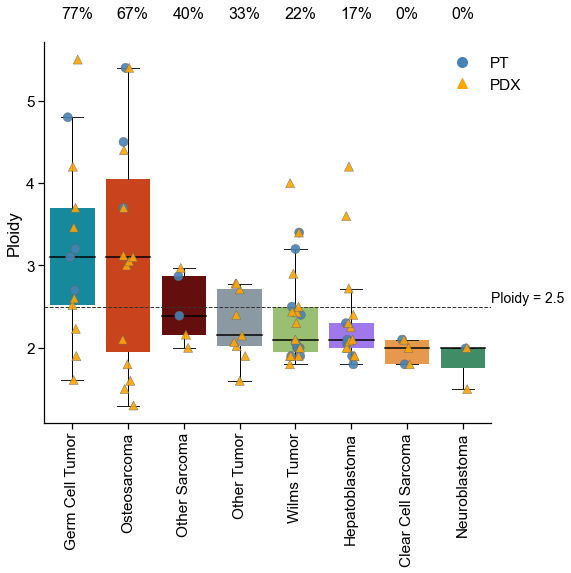

In [19]:
sns.set_context('notebook', font_scale = 1.4, rc = {'lines.linewidth':1}) 
fig = plt.figure(figsize=(8,7))

p = sns.boxplot(data = dm, x = 'Disease Code level 1', y = 'Ploidy',  fliersize=0, 
           order = cancer_ranking, palette= color_ranking,
           boxprops={'edgecolor': 'black', 'alpha':1,'linewidth':0, },  
                medianprops={'color':'black', 'alpha':1, 'linewidth':1.5},
                whiskerprops={'linewidth':1, 'color':'black','alpha' : 1},

           )

sns.stripplot(data = dm[dm['Datatype'] == 'PT'], x = 'Disease Code level 1', y = 'Ploidy', 
              color='steelblue', marker = 'o', size = 9, alpha = 0.9,  linewidth=0.5, edgecolor = '.4',
             order =cancer_ranking)
sns.stripplot(data = dm[dm['Datatype'] == 'PDX'], x = 'Disease Code level 1', y = 'Ploidy', 
              color='orange', marker = '^', size = 9, alpha = 0.9, linewidth=0.5, edgecolor = '.4',
             order =cancer_ranking)
sns.despine()
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Ploidy')

import matplotlib.lines as mlines
legend_elements = [
    mlines.Line2D([], [], color='steelblue', marker='o', linestyle='None', markersize=10, label='PT'),
    mlines.Line2D([], [], color='orange', marker='^', linestyle='None', markersize=10, label='PDX')
]

plt.legend(legend_elements,['PT','PDX'], bbox_to_anchor = (1.1,1), frameon=False)
plt.axhline(y=2.5, xmin=0, xmax=1, linestyle = '--', linewidth = 1, color = '.2')
plt.text(7.5, 2.55, 'Ploidy = 2.5', fontsize = 14)


text_x = [-0.2,0.8,1.8,2.8,3.8,4.8,5.8,6.8]
for i in range(len(pct)):
     plt.text(text_x[i], 6, pct[i], fontsize = 16)


### PDX VS PT

In [64]:
dm2 = data.set_index('PatientID').T[paired_idx].T
dm2['PDX_Ploidy'] = dm1['PDX_Ploidy'].astype(float)
dm2['PT_Ploidy'] = dm1['PT_Ploidy'].astype(float)

cancer_ranking3 = [i for i in cancer_ranking_all if i in list(dm2['Disease Code level 1']) ]
color_ranking3 = [color_ranking_palette[cancer_ranking_all.index(i)]  for i in cancer_ranking3 ]

Text(1.5, 5, 'r=0.98, rho=3.2e-15')

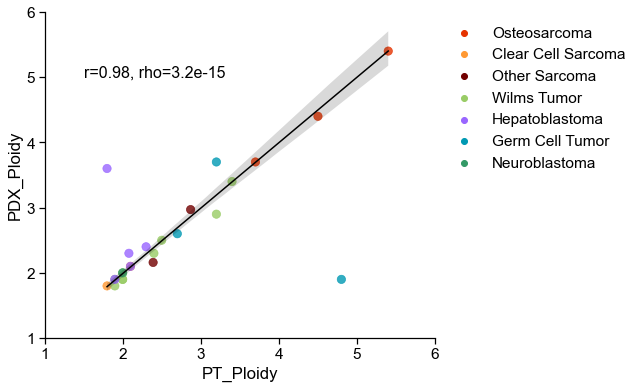

In [77]:
sns.set_context('notebook', font_scale = 1.4, rc = {'lines.linewidth':1}) 
fig = plt.figure(figsize=(7,6))



p = sns.scatterplot(data = dm1, x = 'PT_Ploidy', y = 'PDX_Ploidy', 
                s = 70, edgecolor = None, alpha = 0.8,
                hue = 'Disease Code level 1', hue_order=cancer_ranking3, palette=color_ranking3, 
               )
dk = dm2.reset_index()
dk = dk[(dk['PatientID'] != '1979') & (dk['PatientID'] != '1959')]
p = sns.regplot(data = dk, x = 'PT_Ploidy', y = 'PDX_Ploidy',  color='black', scatter=False, 
              )
p.set_xlim(1,6)
p.set_ylim(1,6)
sns.despine()
plt.legend(bbox_to_anchor = (1,1), frameon = False)

r,p = sp.stats.spearmanr(dk['PT_Ploidy'], dk['PDX_Ploidy'])
plt.text(1.5, 5, 'r={:.2f}, rho={:.2g}'.format(r,p), fontsize = 16)


## 1mb bin

In [193]:
cin = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/4.cnv/Allsample_CIN.by_chr.ratio.20220810.txt', sep='\t', index_col=0)
cin = pd.DataFrame(cin.T.sum() )
cin.columns = ['Total_CIN']
cin = cin.astype(float)

ids = cin[cin['Total_CIN'] <= 0.1].index.str.replace('_PT_WGS','',regex = True).str.replace('_PDX_WGS','',regex = True)
ids

Index(['1753', '1754', '1754', '1853', '1959', '1979', '1982', '2197', '466',
       '498', '498', '530', '533', '560', '560'],
      dtype='object', name='Sample')

In [194]:
data= pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/4.cnv/SEG/Allsample.1mb_bins.ratio.txt', sep = '\t', index_col=[0,1])  
data = data.dropna(axis = 0)
sample_idx = set(data.columns.str.split('_').str[0])
data

,,1739_PDX_WGS,1739_PT_WGS,1753_PDX_WGS,1753_PT_WGS,1754_PDX_WGS,1754_PT_WGS,1763_PDX_WGS,1763_PT_WGS,1792_PDX_WGS,1792_PT_WGS,1795_PDX_WGS,1795_PT_WGS,1823_PDX_WGS,1823_PT_WGS,1826_PDX_WGS,1826_PT_WGS,1853_PDX_WGS,1853_PT_WGS,1907_PDX_WGS,1907_PT_WGS,1912_PDX_WGS,1913_PDX_WGS,1913_PT_WGS,1917_PDX_WGS,1922_PDX_WGS,1922_PT_WGS,1925_PDX_WGS,1932_PDX_WGS,1932_PT_WGS,1939_PDX_WGS,1957_PDX_WGS,1957_PT_WGS,1959_PDX_WGS,1959_PT_WGS,1960_PDX_WGS,1979_PDX_WGS,1979_PT_WGS,1981_PDX_WGS,1982_PDX_WGS,2035_PDX_WGS,2035_PT_WGS,2050_PDX_WGS,2050_PT_WGS,2083_PDX_WGS,2084_PDX_WGS,2129_PDX_WGS,2197_PDX_WGS,2237_PT_WGS,2264_PDX_WGS,2264_PT_WGS,2324_PDX_WGS,29_PT_WGS,462_PDX_WGS,466_PDX_WGS,471_PDX_WGS,494_PDX_WGS,498_PDX_WGS,498_PT_WGS,500_PDX_WGS,511_PDX_WGS,516_PDX_WGS,522_PDX_WGS,529_PDX_WGS,529_PT_WGS,530_PDX_WGS,532_PDX_WGS,533_PDX_WGS,543_PDX_WGS,54_PDX_WGS,54_PT_WGS,556_PDX_WGS,560_PDX_WGS,560_PT_WGS,561_PDX_WGS,564-Dup_PDX_WGS,564_PDX_WGS,585_PDX_WGS,585_PT_WGS,652_PT_WGS,655_PDX_WGS,655_PT_WGS,668_PDX_WGS,668_PT_WGS,875194_PDX_WGS,883129_PDX_WGS,891173_PDX_WGS,891760_PDX_WGS,892257_PDX_WGS,895452_PDX_WGS,896751_PDX_WGS
Num,W,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,chr1:1000000:2000000,-0.087326,-0.080265,-0.181206,-0.005137,-0.005829,0.007243,-0.642206,-0.112111,0.834861,0.642599,-0.653147,-0.226577,-0.635308,-0.099330,0.413875,0.306336,-0.076487,-0.100590,0.511094,0.30892,-0.250668,0.041945,0.026412,-0.189359,0.717921,0.861180,0.025477,0.023022,0.039492,-0.004305,-0.041656,-0.023320,-0.42724,-0.020652,-0.212639,0.009887,0.029080,0.188312,-0.132084,0.334286,0.239279,-0.229150,-0.159020,-0.178151,0.128627,-0.170691,-0.092211,-0.112035,-0.015958,0.003695,-0.121241,-0.069050,0.307474,-0.037806,0.385125,0.085469,-0.003795,0.000925,0.240097,-0.033064,0.540604,0.417673,0.055758,0.003785,0.144320,0.107150,-0.114317,-0.108776,1.005540,0.800885,-0.037933,0.019113,-0.001059,0.026316,0.500793,0.456666,0.005312,-0.131608,-0.057942,-0.023782,-0.008622,0.006727,0.010149,0.265006,-0.284634,-0.166512,0.002208,-0.399224,-0.102301,0.523781
1,chr1:2000000:3000000,-0.087326,-0.080265,-0.181206,-0.005137,-0.005829,0.007243,-0.642206,-0.112111,0.834861,0.642599,-0.653147,-0.226577,-0.635308,-0.099330,0.413875,0.306336,-0.076487,-0.100590,0.511094,0.30892,-0.250668,0.041945,0.026412,-0.189359,0.717921,0.861180,0.025477,0.023022,0.039492,-0.004305,-0.041656,-0.023320,-0.42724,-0.020652,-0.212639,0.009887,0.029080,0.188312,-0.132084,0.334286,0.239279,-0.229150,-0.159020,-0.178151,0.128627,-0.170691,-0.092211,-0.112035,-0.015958,0.003695,-0.121241,-0.069050,0.307474,-0.037806,0.385125,0.085469,-0.003795,0.000925,0.240097,-0.033064,0.540604,0.417673,0.055758,0.003785,0.144320,0.107150,-0.114317,-0.108776,1.005540,1.083960,-0.037933,0.019113,-0.001059,0.026316,0.500793,0.456666,0.005312,-0.131608,-0.057942,-0.023782,-0.008622,0.006727,0.010149,0.265006,-0.284634,-0.166512,-0.050949,-0.399224,-0.102301,0.523781
2,chr1:3000000:4000000,-0.087326,-0.080265,-0.181206,-0.005137,-0.005829,0.007243,-0.642206,-0.112111,0.834861,0.642599,-0.653147,-0.226577,-0.635308,-0.099330,0.413875,0.306336,-0.076487,-0.100590,0.511094,0.30892,-0.250668,0.041945,0.026412,-0.189359,0.717921,0.861180,0.025477,0.023022,0.039492,-0.004305,-0.041656,-0.023320,-0.42724,-0.020652,-0.212639,0.009887,0.029080,0.188312,-0.132084,0.334286,0.239279,-0.229150,-0.159020,-0.178151,0.128627,-0.170691,-0.092211,-0.112035,-0.015958,0.003695,-0.121241,-0.069050,0.307474,-0.037806,0.385125,0.085469,-0.003795,0.000925,0.240097,-0.033064,0.540604,0.417673,0.055758,0.003785,0.144320,0.107150,-0.114317,-0.108776,0.836613,0.867418,-0.037933,0.019113,-0.001059,0.026316,0.500793,0.456666,0.005312,-0.131608,-0.057942,-0.023782,-0.008622,0.006727,0.010149,0.265006,-0.284634,-0.166512,-0.050949,-0.399224,-0.102301,0.523781
3,chr1:4000000:5000000,-0.087326,-0.080265,-0.181206,-0.005137,-0.005829,0.007243,-0.642206,-0.112111,0.834861,0.642599,-0.653147,-0.226577,-0.63

### PT-PDX paired


In [195]:
idx = data.columns.str.split('_').str[0]

import collections
paired_idx = [item for item, count in collections.Counter(idx).items() if count > 1]
print(len(paired_idx))
paired_idx = [i for i in paired_idx if ( i not in ['1853', '1796'] ) & (i not in [ '1754', '498', '560','668','1753','1959','1979'] )]  #CIN > 2
print(len(paired_idx))


26
18


In [196]:
df = data.reset_index().drop(['Num', 'W'], axis = 1).T
df['PatientID'] = list(df.index.str.split('_').str[0])
df = df.reset_index().set_index('PatientID').T
df = df[[i for i in paired_idx if i in list(df.columns) ]].T.reset_index()
df = add_cancer_info(df, 'PatientID')
df = df.set_index('Disease Code level 1').T[[i for i in cancer_ranking_all if  i in list(df['Disease Code level 1'])]]
df = df.T
df = df.reset_index().set_index('index')
ht = df[list(range(len(data)))].T

In [197]:
cor =  ht.astype(float).corr(method = 'pearson')

corr = cor
corr = corr.filter(regex = 'PDX').T.filter(regex = 'PT')
corr.columns = corr.columns.str.replace('_WGS', '', regex = True)
corr.index = corr.index.str.replace('_WGS', '', regex = True)

corr

index,1792_PT,1922_PT,2035_PT,529_PT,1907_PT,54_PT,1763_PT,1823_PT,1932_PT,2050_PT,2264_PT,655_PT,1739_PT,1957_PT,585_PT,1795_PT,1826_PT,1913_PT
index,,,,,,,,,,,,,,,,,,
1792_PDX,0.917055,0.240217,0.155798,0.172092,0.083182,0.219867,0.128943,-0.158683,-0.051427,-0.116591,0.062041,-0.155861,0.206811,0.098389,0.134609,-0.006900,0.101559,0.113868
1922_PDX,0.286656,0.921031,0.044381,0.009219,0.229129,0.025114,-0.072331,-0.208848,-0.029941,-0.038036,0.010485,-0.209616,0.218519,0.291700,0.149661,0.090726,0.139220,0.141498
2035_PDX,0.263583,0.284072,0.693619,0.215086,0.160390,0.113689,0.239071,-0.149380,-0.017351,0.066652,0.050316,0.085923,0.153470,0.286076,0.240846,0.193208,0.385286,0.189247
529_PDX,0.119786,0.009240,0.284986,0.844385,0.180360,0.346457,0.268451,0.040157,0.103228,0.239129,0.083105,0.157229,0.189786,0.207549,0.228364,0.290891,0.336335,0.429152
1907_PDX,0.061609,0.193363,0.218576,0.243727,0.935023,0.309601,0.062199,0.102995,0.006569,0.265619,0.205521,0.252859,0.031737,0.340534,0.395149,0.516363,0.359190,-0.015878
54_PDX,0.173783,0.055776,0.330826,0.325473,0.326501,0.985253,0.435658,0.263781,0.032294,0.264846,0.178378,0.165570,0.251298,0.529013,0.456741,0.415511,0.487126,0.269200
1763_PDX,-0.081480,-0.059195,0.214306,0.094797,0.015936,0.155974,0.735232,0.071642,0.089085,0.020981,0.013636,0.086592,0.472815,0.166240,-0.042495,0.194095,0.114716,0.231437
1823_PDX,-0.134565,-0.259956,0.012890,0.062161,0.184421,0.285146,0.126607,0.760907,0.184142,0.305769,0.278689,0.357134,-0.370676,0.214123,0.425479,0.198231,0.266562,-0.030155
1932_PDX,-0.066374,0.023153,-0.020942,0.088493,0.015738,-0.083481,0.126330,0.149378,0.984714,-0.109067,0.658903,0.107772,-0.173734,-0.115278,-0.042903,0.012749,0.038393,0.101713


In [89]:
m = corr.reset_index()
m['PatientID'] = m['index'].str.split("_").str[0]
labels = add_cancer_info(m, 'PatientID')['Disease Code level 2'].to_list()
lut = dict(zip(cancer_ranking_all2, [mpl.colors.to_rgb(i)  for i in color_ranking_palette2]))   
row_colors = pd.DataFrame(labels)[0].map(lut)

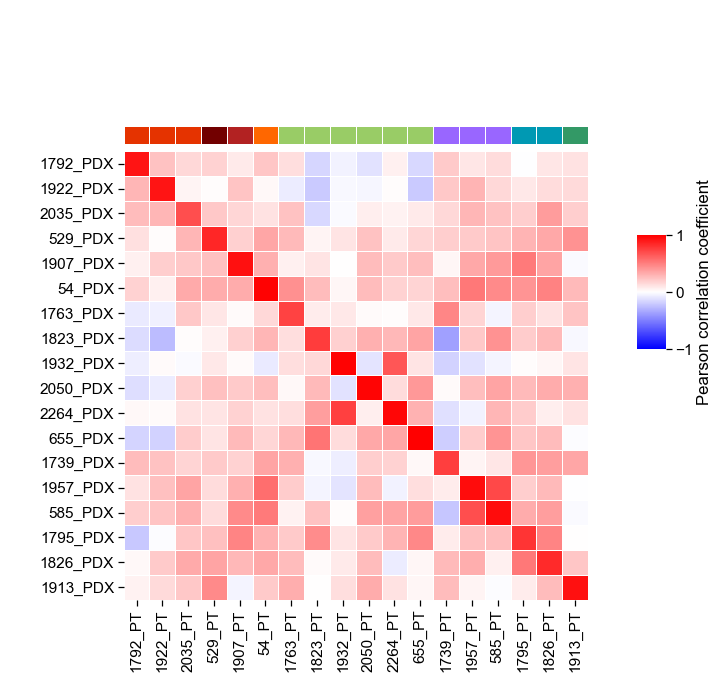

In [104]:
sns.set_context('notebook', font_scale = 1.4, rc = {'lines.linewidth':1}) 

g = sns.clustermap(corr.fillna(0), cmap = 'bwr', col_colors=[row_colors],# row_colors=[row_colors],
                   col_cluster=False, row_cluster=False,
                vmin =-1,  center = 0, vmax = 1,
                   cbar_kws={'label': 'Pearson correlation coefficient'}, linewidths=1, linecolor='white',
                   #yticklabels=False,xticklabels=False,
                  )
#gap of row_color and heatmap
bbox = g.ax_heatmap.get_position()
space = .01
g.ax_heatmap.set_position([bbox.x0, bbox.y0, bbox.width, bbox.height - space])

#change label to left
g.ax_heatmap.tick_params(axis='y', labelright=False,labelleft=True,right=False, left=True)
g.ax_heatmap.set(xlabel='', ylabel = '')

#cbar position
x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([0.9, 0.5, g.ax_row_dendrogram.get_position().width/4, g.ax_row_dendrogram.get_position().height/4])

In [109]:
overall_cor = pd.DataFrame(np.diag(corr), index = corr.index.str.replace('_PDX','',regex = True), columns = [ 'Correlation'] ).sort_values('Correlation')
overall_cor

,Correlation
index,
2035,0.693619
1763,0.735232
1739,0.752137
1823,0.760907
1795,0.793577
1826,0.834000
529,0.844385
1792,0.917055
1922,0.921031


## CGC

In [126]:
cgc = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/4.cnv/CGC/all.ratio.txt', sep = '\t', index_col=0)
cgc.columns = cgc.columns.str.replace('_WGS', '', regex = True)
cor_cgc =cgc.corr(method='pearson')


In [127]:
m = cor_cgc.reset_index()
m['PatientID'] = m['index'].str.split('_').str[0]
m = add_cancer_info(m,'PatientID').set_index('Disease Code level 1').T[[i for i in cancer_ranking_all if  i in list(m['Disease Code level 1'])]].T['PatientID'].unique()

idx = cor_cgc.columns.str.split('_').str[0]

import collections
paired_idx = [item for item, count in collections.Counter(idx).items() if count > 1]
paired_idx = [i for i in paired_idx if ( i not in ['1853', '1796'] ) & (i not in [ '1754', '498', '560', '668','1753','1959','1979']) ] 

cor_cgc = cor_cgc[[i+'_PDX' for i in m if i  in paired_idx]].T[[i+'_PT' for i in m if i  in paired_idx]]

Text(0.5, 1.0, 'CGC')

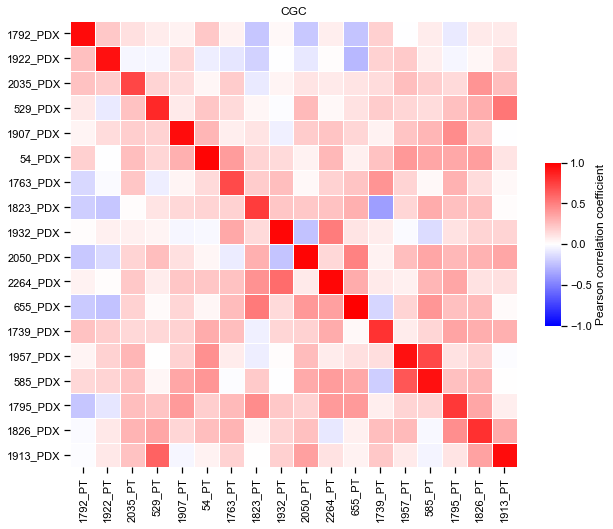

In [128]:
sns.set_context('notebook', font_scale = 1, rc = {'lines.linewidth':1}) 
fig = plt.figure(figsize=(10,10))

g = sns.heatmap(cor_cgc, cmap = 'bwr', square=True, 
            center = 0, vmax = 1, vmin = -1,
            cbar_kws={"shrink": .3, "aspect":10, 'label': "Pearson correlation coefficient"}, linewidths=1, linecolor='white',
            )
g.set_title('CGC')

In [686]:
pd.DataFrame(np.diag(cor_cgc), index = cor_cgc.index.str.split('_').str[0], columns = ['Correlation']).sort_values('Correlation')

,Correlation
1763,0.705136
2035,0.725618
1823,0.760048
1795,0.778558
1739,0.797326
1826,0.810370
529,0.843542
1922,0.932154
585,0.932838
1957,0.936923


## focal CN


### Number of focal CN

In [105]:
focal = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/4.cnv/Focal/focal_cn.similarity.rescue.txt', sep = '\t')
focal = focal[focal['Sample'] != 1853]
focal = focal.set_index('Sample')[['PT_shared','PT_only','PDX_shared','PDX_only']].sort_values('PT_shared', ascending = False)
focal

,PT_shared,PT_only,PDX_shared,PDX_only
Sample,,,,
54,53,2,41,3
1907,20,2,35,1
1792,19,1,20,3
2035,8,0,15,12
1922,6,2,9,1
1763,4,3,7,1
529,4,3,1,0
1739,3,2,4,1
1795,1,1,0,1


<ipython-input-106-a3f1644e9664>:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('red'), linestyle='None'))
<ipython-input-106-a3f1644e9664>:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('green'),  linestyle='None'))
<ipython-input-106-a3f1644e9664>:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('skyblue'), linestyle='None'))


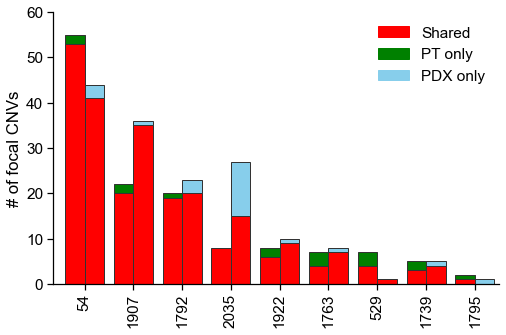

In [106]:
sns.set_context('notebook', font_scale = 1.4, rc = {'lines.linewidth':1}) 
fig, ax = plt.subplots(figsize = (8,5))

focal[['PDX_shared','PDX_only']].plot(kind='bar', stacked=True, color=[ 'red','skyblue'], width = 0.4,
                               ax = ax, position=0, edgecolor='.2')
focal[['PT_shared','PT_only']].plot(kind='bar', stacked=True, color=[ 'red',  'green'], width = 0.4, 
                              ax = ax, position=1, edgecolor='.2')
ax.set_xlim(right=len(focal)-0.5)
plt.xlabel('')
plt.ylabel('# of focal CNVs')
plt.ylim(0,60)
sns.despine() 

import matplotlib.patches as mpatches
legend_elements = []
legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('red'), linestyle='None'))
legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('green'),  linestyle='None'))
legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('skyblue'), linestyle='None'))
plt.legend(legend_elements, ['Shared', 'PT only', 'PDX only'], bbox_to_anchor = (1,1), frameon=False)


In [652]:
focal['Percentage_PT'] = focal['PT_shared'] / (focal['PT_shared'] + focal['PT_only'])
focal['Percentage_PDX'] = focal['PDX_shared'] / (focal['PDX_shared'] + focal['PDX_only'])
focal[['Percentage_PT','Percentage_PDX']].reset_index() 

,Sample,Percentage_PT,Percentage_PDX
0,54,0.963636,0.931818
1,1907,0.909091,0.972222
2,1792,0.950000,0.869565
3,2035,1.000000,0.555556
4,1922,0.750000,0.900000
5,1763,0.571429,0.875000
6,529,0.571429,1.000000
7,1739,0.600000,0.800000
8,1795,0.500000,0.000000


### Length of focal CN

In [111]:
length = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/4.cnv/Focal/Paired_sample.focal.all.txt', sep = '\t', header=None)
length.columns = ['PatientID','Datatype','Chr','St','Ed', 'Length','Type']
length = length[length['PatientID'] != 1853]
df = length.groupby(['Datatype' ,'PatientID','Type']).sum()[['Length']].unstack('Type').fillna(0).astype(int)
df.columns = ['Rescued','Shared','Specific']
df = df/1000000  #1mb

df =df[['Shared', 'Rescued', 'Specific']]
df = df.reset_index().set_index('PatientID').T[focal.index].T
df['Shared'] = df['Shared'] + df['Rescued']
df =df.drop('Rescued', axis = 1)
df 

,Datatype,Shared,Specific
PatientID,,,
54,PDX,381.871452,1.386768
54,PT,418.139504,4.569369
1907,PDX,353.157564,3.951882
1907,PT,125.177511,0.208121
1792,PDX,281.628532,85.670919
1792,PT,285.28568,3.050924
2035,PDX,367.868475,94.451059
2035,PT,233.063844,0.0
1922,PDX,154.741999,6.394786


<ipython-input-112-644cb2691ce8>:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('coral'), linestyle='None'))
<ipython-input-112-644cb2691ce8>:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('lightseagreen'),  linestyle='None'))
<ipython-input-112-644cb2691ce8>:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('lightblue'), linestyle='None'))


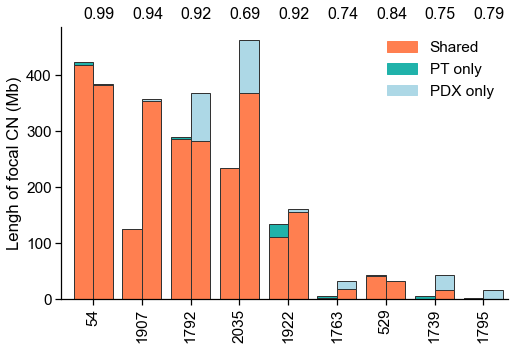

In [112]:
sns.set_context('notebook', font_scale = 1.4, rc = {'lines.linewidth':1}) 
fig, ax = plt.subplots(figsize = (8,5))

df[df['Datatype'] == 'PDX'].plot(kind='bar', stacked=True, color=[ 'coral','lightblue'], width = 0.4,
                               ax = ax, position=0, edgecolor='.2')
df[df['Datatype'] == 'PT'].plot(kind='bar', stacked=True, color=[ 'coral','lightseagreen'], width = 0.4, 
                              ax = ax, position=1, edgecolor='.2')
ax.set_xlim(right=len(focal)-0.5)
plt.xlabel('')
plt.ylabel('Lengh of focal CN (Mb)')
#plt.ylim(0,60)
sns.despine() 

import matplotlib.patches as mpatches
legend_elements = []
legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('coral'), linestyle='None'))
legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('lightseagreen'),  linestyle='None'))
legend_elements.append(mpatches.Patch([], [], color=mpl.colors.to_hex('lightblue'), linestyle='None'))
plt.legend(legend_elements, ['Shared', 'PT only', 'PDX only'], bbox_to_anchor = (1,1), frameon=False)


txt = overall_cor.T[[ str(i) for i in list(df.index.unique())]].T['Correlation'].to_list()
txt = ['{0:.2f}'.format(float(i)) for i in txt]
text_x = [-0.2,0.8,1.8,2.8,3.8,4.8,5.8,6.8,7.8]
for i in range(len(txt)):
     plt.text(text_x[i], 500, txt[i], fontsize = 16)


In [657]:
overall_cor = pd.DataFrame(np.diag(corr), index = corr.index.str.replace('_PDX','',regex = True), columns = [ 'Correlation'] ).sort_values('Correlation')
overall_cor

,Correlation
index,
2035,0.693619
1763,0.735232
1739,0.752137
1823,0.760907
1795,0.793577
1826,0.834000
529,0.844385
1792,0.917055
1922,0.921031


## CIN distribution

In [138]:
data = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/4.cnv/Allsample_CIN.by_chr.ratio.20220810.txt', sep='\t', index_col=0)
data['PatientID'] = data.index.str.split('_').str[0]
df =pd.concat([data.drop('PatientID', axis = 1), info.set_index('Sample')[['Disease Code level 2', 'Disease Code level 1']]], axis = 1)
df

,amp_1_p,amp_1_q,amp_2_p,amp_2_q,amp_3_p,amp_3_q,amp_4_p,amp_4_q,amp_5_p,amp_5_q,amp_6_p,amp_6_q,amp_7_p,amp_7_q,amp_8_p,amp_8_q,amp_9_p,amp_9_q,amp_10_p,amp_10_q,amp_11_p,amp_11_q,amp_12_p,amp_12_q,amp_13_p,amp_13_q,amp_14_p,amp_14_q,amp_15_p,amp_15_q,amp_16_p,amp_16_q,amp_17_p,amp_17_q,amp_18_p,amp_18_q,amp_19_p,amp_19_q,amp_20_p,amp_20_q,amp_21_p,amp_21_q,amp_22_p,amp_22_q,del_1_p,del_1_q,del_2_p,del_2_q,del_3_p,del_3_q,del_4_p,del_4_q,del_5_p,del_5_q,del_6_p,del_6_q,del_7_p,del_7_q,del_8_p,del_8_q,del_9_p,del_9_q,del_10_p,del_10_q,del_11_p,del_11_q,del_12_p,del_12_q,del_13_p,del_13_q,del_14_p,del_14_q,del_15_p,del_15_q,del_16_p,del_16_q,del_17_p,del_17_q,del_18_p,del_18_q,del_19_p,del_19_q,del_20_p,del_20_q,del_21_p,del_21_q,del_22_p,del_22_q,Disease Code level 2,Disease Code level 1
Sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1739_PDX_WGS,0.000000,0.604005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000725,0.000000,0.000000,0.000000,0.000000,0.000000,0.189661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001086,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,Hepatoblastoma,Hepatoblastoma
1739_PT_WGS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.028418,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001086,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,Hepatoblastoma,Hepatoblastoma
1753_PDX_WGS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,NaN,0.000000,NaN,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,1.000000,Wilms Tumor,Wilms Tumor
1753_PT_WGS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,0.000000,Wilms 

In [140]:
info = add_cancer_info(data[[ 'PatientID']].reset_index(), 'PatientID')
dt = info.set_index(['Disease Code level 2','Disease Code level 1', 'Sample'])
dt['Total_amp'] = df.reset_index().set_index(['Disease Code level 2','Disease Code level 1', 'Sample']).filter(regex = 'amp_').T.mean() 
dt['Total_del'] = df.reset_index().set_index(['Disease Code level 2','Disease Code level 1', 'Sample']).filter(regex = 'del_').T.mean() 
dt['Total_CIN'] = dt['Total_amp'] + dt['Total_del']

dt = dt.reset_index()
dt['Datatype'] = dt['Sample'].str.split('_').str[1]
dt

,Disease Code level 2,Disease Code level 1,Sample,PatientID,PDXID,Tumor Class,Primary or Met,Gender,Age(year),Therapy prior to PDX collection,Total_amp,Total_del,Total_CIN,Datatype
0,Hepatoblastoma,Hepatoblastoma,1739_PDX_WGS,1739,1739,Hepatoblastoma,primary,Male,2.0,no treatment,0.104636,0.004352,0.108988,PDX
1,Hepatoblastoma,Hepatoblastoma,1739_PT_WGS,1739,1739,Hepatoblastoma,primary,Male,2.0,no treatment,0.045498,0.024093,0.069592,PT
2,Wilms Tumor,Wilms Tumor,1753_PDX_WGS,1753,1753,"nephroblastoma, nos",primary,Male,10.0,No treatment,0.000000,0.175000,0.175000,PDX
3,Wilms Tumor,Wilms Tumor,1753_PT_WGS,1753,1753,"nephroblastoma, nos",primary,Male,10.0,No treatment,0.000000,0.000000,0.000000,PT
4,Clear Cell Sarcoma,Clear Cell Sarcoma,1754_PDX_WGS,1754,1754,"Clear cell sarcoma, NOS",primary,Male,1.0,No treatment,0.000000,0.000000,0.000000,PDX
5,Clear Cell Sarcoma,Clear Cell Sarcoma,1754_PT_WGS,1754,1754,"Clear cell sarcoma, NOS",primary,Male,1.0,No treatment,0.000000,0.000000,0.000000,PT
6,Wilms Tumor,Wilms Tumor,1763_PDX_WGS,1763,1763,"Nephroblastoma, NOS (Wilms tumor)",primary,Female,1.0,No treatment,0.178414,0.318557,0.496971,PDX
7,Wilms Tumor,Wilms Tumor,1763_PT_WGS,1763,1763,"Nephroblastoma, NOS (Wilms tumor)",primary,Female,1.0,No treatment,0.000071,0.137975,0.138046,PT
8,Osteosarcoma,Osteosarcoma,1792_PDX_WGS,1792,1792,Metastatic Osteosarcoma,primary,Female,17.0,Chemotherapy,0.357728,0.498426,0.856154,PDX
9,Osteosarcoma,Osteosarcoma,1792_PT_WGS,1792,1792,Metastatic Osteosarcoma,primary,Female,17.0,Chemotherapy,0.288168,0.478235,0.766403,PT


### Allsample (Boxplot)

In [142]:
dk = dt

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


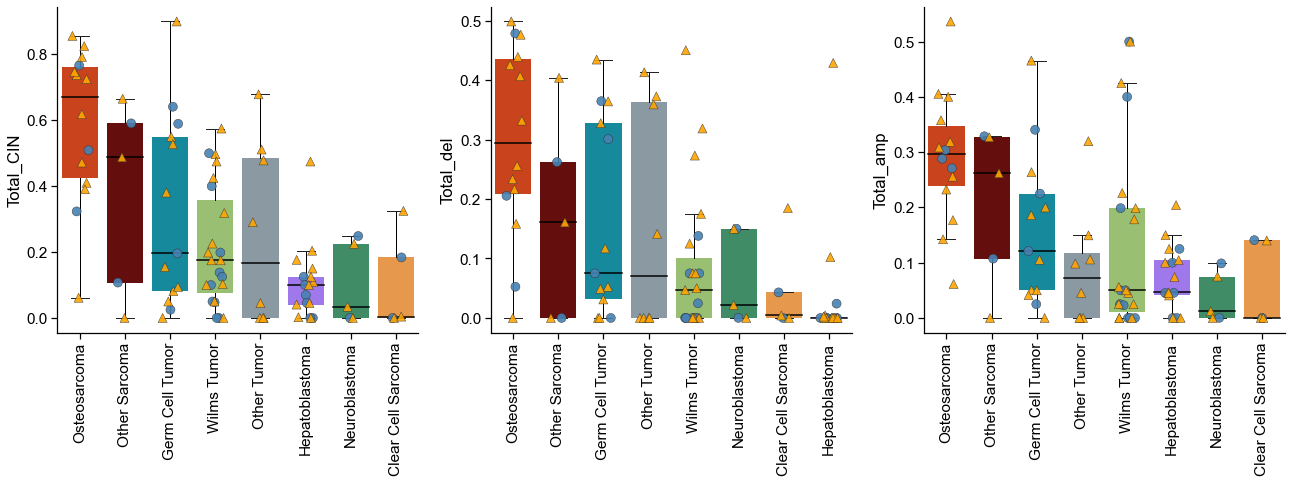

In [145]:
sns.set_context('notebook',font_scale = 1.4, rc = {'lines.linewidth':1}) #设置文本
fig = plt.figure(figsize=(22,6))

gs = gridspec.GridSpec( 1,3, hspace=0.5 , width_ratios=[1,1,1]) #不同图片间隔
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

X = 'Disease Code level 1'
Y = 'Total_CIN'
plot_box_with_ax_datatype(dk, X, Y, ax1)

Y = 'Total_del'
plot_box_with_ax_datatype(dk, X, Y, ax2)

Y = 'Total_amp'
plot_box_with_ax_datatype(dk, X, Y, ax3)


### PT-PDX paired

In [165]:
def plot_reg_scatter(dk, X, Y, k, ax):
    X = k + '_PT'
    Y = k + '_PDX'

    sns.regplot(data = dk, y = Y, x = X, scatter=False, ci = 95, color='black',ax = ax,truncate=False)
    sns.scatterplot(data = dk, y = Y, x = X, s = 100,
                    hue = 'Disease Code level 1', hue_order=cancer_ranking, palette=color_ranking, linewidth = 0,
                    ax = ax
                    )
    r,p = sp.stats.spearmanr(dk[X], dk[Y])
    ax.text(0.05, 0.85, 'rho = {:.2f}, p = {:.2g}'.format(r,p), fontsize = 16)
    ax.get_legend().remove()
    #ax.legend(loc = 1, bbox_to_anchor=(1.5,1),frameon = False)

    sns.despine()

In [147]:
idx = dt['Sample'].str.split('_').str[0]

import collections
paired_idx = [item for item, count in collections.Counter(idx).items() if count > 1]
paired_idx = [i for i in paired_idx if ( i not in ['1853', '1796'] )  ] 
print(len(paired_idx))

25


In [148]:
dk = dt.set_index('PatientID').T[paired_idx].T[['Datatype','Total_amp','Total_del','Total_CIN', 'Disease Code level 1']].reset_index().set_index(['Disease Code level 1', 'PatientID', 'Datatype']).unstack('Datatype')
dk.columns = ['Total_amp_PDX', 'Total_amp_PT', 'Total_del_PDX', 'Total_del_PT', 'Total_CIN_PDX', 'Total_CIN_PT']
dk = dk.astype(float).reset_index()
dk

,Disease Code level 1,PatientID,Total_amp_PDX,Total_amp_PT,Total_del_PDX,Total_del_PT,Total_CIN_PDX,Total_CIN_PT
0,Clear Cell Sarcoma,1754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Clear Cell Sarcoma,529,0.140228,0.140831,0.184772,0.043014,0.325000,0.183845
2,Germ Cell Tumor,1795,0.185943,0.225000,0.364057,0.364425,0.550000,0.589425
3,Germ Cell Tumor,1826,0.465606,0.340432,0.434394,0.300771,0.900000,0.641203
4,Germ Cell Tumor,1979,0.000000,0.121073,0.000000,0.075000,0.000000,0.196073
5,Hepatoblastoma,1739,0.104636,0.045498,0.004352,0.024093,0.108988,0.069592
6,Hepatoblastoma,1957,0.125000,0.125000,0.000000,0.000000,0.125000,0.125000
7,Hepatoblastoma,1959,0.046250,0.000000,0.428750,0.000000,0.475000,0.000000
8,Hepatoblastoma,498,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Hepatoblastoma,585,0.100000,0.100000,0.000000,0.000000,0.100000,0.100000


In [149]:

cancer_ranking = [i for i in cancer_ranking_all if i in list(dk['Disease Code level 1'].unique())]
color_ranking = [color_ranking_palette[cancer_ranking_all.index(i)]  for i in cancer_ranking ]
color_ranking

[(0.8999999999999999, 0.19999999999999996, 0.0, 1.0),
 (1.0, 0.6000000000000001, 0.20000000000000018, 1.0),
 (0.44705882352941173, 0.0, 0.0, 1.0),
 (0.6, 0.8, 0.4, 1.0),
 (0.6, 0.4, 1.0, 1.0),
 (0.0, 0.6, 0.7, 1.0),
 (0.2, 0.6, 0.4, 1.0)]

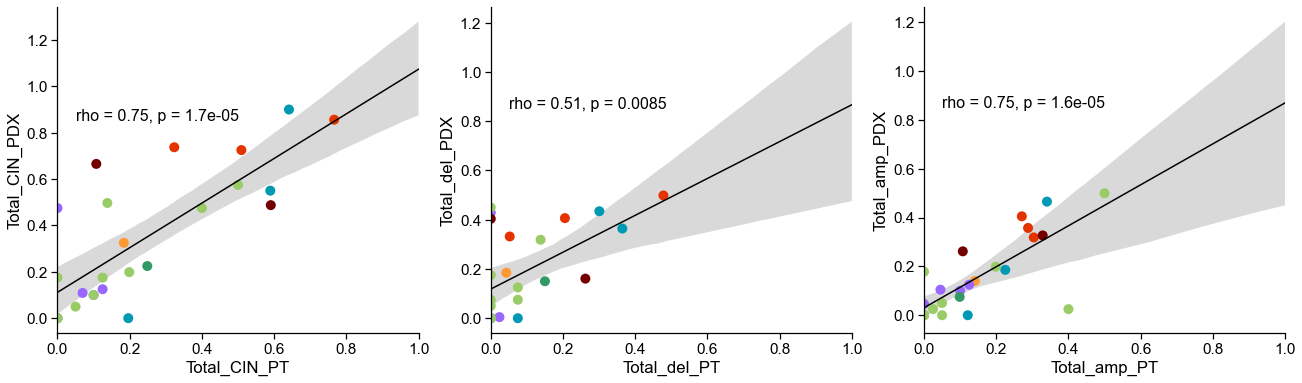

In [164]:
sns.set_context('notebook',font_scale = 1.4, rc = {'lines.linewidth':1}) #设置文本
fig = plt.figure(figsize=(22,6))

gs = gridspec.GridSpec( 1,3, hspace=0.5 , width_ratios=[1,1,1]) #不同图片间隔
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

X = 'Disease Code level 1'
Y = 'Total_CIN'
plot_reg_scatter(dk, X, Y, 'Total_CIN', ax1)

Y = 'Total_del'
plot_reg_scatter(dk, X, Y, 'Total_del', ax2)

Y = 'Total_amp'
plot_reg_scatter(dk, X, Y, 'Total_amp', ax3)


## CNV summary (use 1MB bin ratio file)

In [176]:
cutoff = 0.3

In [177]:
data = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/4.cnv/Allsample_CIN.by_chr.ratio.20220810.txt', sep='\t', index_col=0)
data['PatientID'] = data.index.str.split('_').str[0]
data['Datatype'] = data.index.str.split('_').str[1]

info = add_cancer_info(data.reset_index(), 'PatientID')

num = info.groupby(['Disease Code level 2']).count()[['Sample']]
data

,amp_1_p,amp_1_q,amp_2_p,amp_2_q,amp_3_p,amp_3_q,amp_4_p,amp_4_q,amp_5_p,amp_5_q,amp_6_p,amp_6_q,amp_7_p,amp_7_q,amp_8_p,amp_8_q,amp_9_p,amp_9_q,amp_10_p,amp_10_q,amp_11_p,amp_11_q,amp_12_p,amp_12_q,amp_13_p,amp_13_q,amp_14_p,amp_14_q,amp_15_p,amp_15_q,amp_16_p,amp_16_q,amp_17_p,amp_17_q,amp_18_p,amp_18_q,amp_19_p,amp_19_q,amp_20_p,amp_20_q,amp_21_p,amp_21_q,amp_22_p,amp_22_q,del_1_p,del_1_q,del_2_p,del_2_q,del_3_p,del_3_q,del_4_p,del_4_q,del_5_p,del_5_q,del_6_p,del_6_q,del_7_p,del_7_q,del_8_p,del_8_q,del_9_p,del_9_q,del_10_p,del_10_q,del_11_p,del_11_q,del_12_p,del_12_q,del_13_p,del_13_q,del_14_p,del_14_q,del_15_p,del_15_q,del_16_p,del_16_q,del_17_p,del_17_q,del_18_p,del_18_q,del_19_p,del_19_q,del_20_p,del_20_q,del_21_p,del_21_q,del_22_p,del_22_q,PatientID,Datatype
Sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1739_PDX_WGS,0.000000,0.604005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000725,0.000000,0.000000,0.000000,0.000000,0.000000,0.189661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001086,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,1739,PDX
1739_PT_WGS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.028418,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001086,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,1739,PT
1753_PDX_WGS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,NaN,0.000000,NaN,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,1.000000,1753,PDX
1753_PT_WGS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,0.000000,1753,PT
1754_PDX_WGS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

### PT -PDX separate

In [190]:
ct_select = ['Wilms Tumor',  'Hepatoblastoma','Germ Cell Tumor', 'Osteosarcoma' ]
num = info.groupby([ 'Disease Code level 2', 'Datatype']).count()[['Sample']]
num                                                        

Sample
Disease Code level 2       Datatype        
Adenocarcinoma             PDX            1
Adrenal cortical carcinoma PDX            2
Clear Cell Sarcoma         PDX            3
                           PT             2
ERMS                       PDX            1
                           PT             1
Ewing Sarcoma              PDX            1
Germ Cell Tumor            PDX            9
                           PT             4
Glioblastoma               PDX            1
Hepatoblastoma             PDX           11
                           PT             6
Medulloblastoma            PDX            2
Mesothelioma               PDX            1
Neuroblastoma              PDX            3
                           PT             2
Osteosarcoma               PDX           11
                           PT             3
Ovarian tumor              PDX            1
Pleomorphic Sarcoma        PDX            1
                           PT             1
Wilms Tumor                PDX           13
                           PT            10

In [191]:
seg = pd.read_table('/home/UTHSCSA/hef/2.Project/5.PDX/2.analysis/4.cnv/SEG/Allsample.1mb_bins.ratio.txt', sep = '\t', index_col=[0,1])
seg = seg.fillna(0)

a = seg.astype(float)
a[a>cutoff] = 1
a[a<=cutoff] = 0

amp_pct = pd.concat([info.set_index('Sample')[['Disease Code level 2','Datatype']], a.T] , axis = 1).groupby(['Disease Code level 2','Datatype']).sum()/np.array(num)
amp_pct = amp_pct*100
amp_pct = amp_pct.T
amp_pct.index = seg.index
amp_pct = amp_pct.reset_index()
amp_pct['Chr'] = amp_pct['W'].str.split(':').str[0].replace('chr','',regex = True)
amp_pct['X'] = amp_pct.index


b = seg.astype(float)
b[b>=-cutoff] = 0
b[b<-cutoff] = 1

del_pct = pd.concat([info.set_index('Sample')[['Disease Code level 2','Datatype']], b.T] , axis = 1).groupby(['Disease Code level 2','Datatype']).sum()/np.array(num)
del_pct = del_pct*-100
del_pct = del_pct.T
del_pct.index = seg.index
del_pct = del_pct.reset_index()
del_pct['Chr'] = del_pct['W'].str.split(':').str[0].replace('chr','',regex = True)
del_pct['X'] = del_pct.index 

In [192]:
chr_bin = del_pct[['X', 'W','Chr']]
chr_bin = chr_bin[chr_bin['Chr']!='X']
chr_bin = pd.concat([chr_bin.groupby('Chr').min()[['X']], chr_bin.groupby('Chr').max()[['X']]] ,  axis =1)
chr_bin.columns = ['st', 'ed'] 
chr_bin = chr_bin.reset_index().astype(int).set_index('Chr')
chr_bin =chr_bin.T[list(range(1,23))].T
chr_bin['mid'] = (chr_bin['st'] + chr_bin['ed']) / 2
chr_bin = chr_bin.reset_index()

<ipython-input-192-d41581494088>:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  chr_bin = pd.concat([chr_bin.groupby('Chr').min()[['X']], chr_bin.groupby('Chr').max()[['X']]] ,  axis =1)
<ipython-input-192-d41581494088>:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  chr_bin = pd.concat([chr_bin.groupby('Chr').min()[['X']], chr_bin.groupby('Chr').max()[['X']]] ,  axis =1)


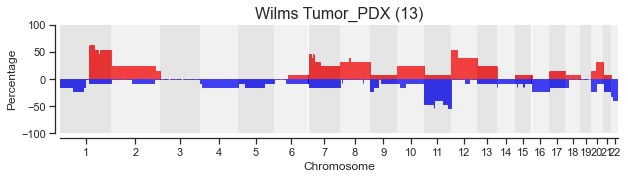

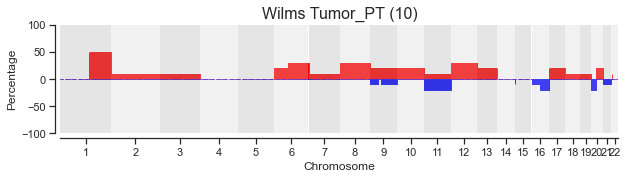

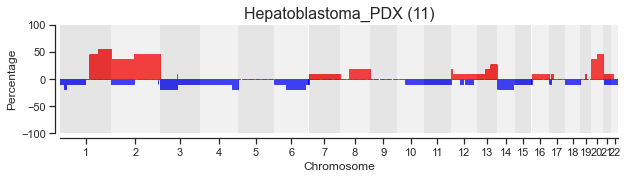

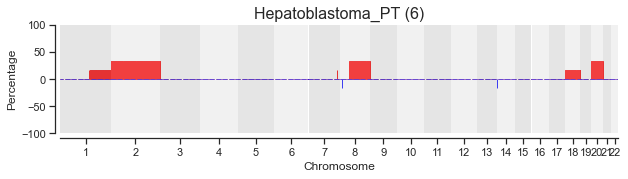

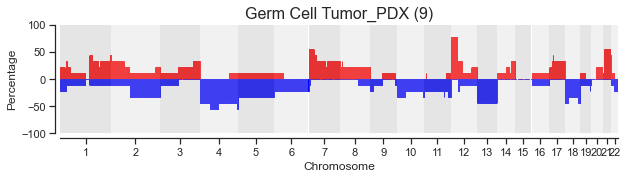

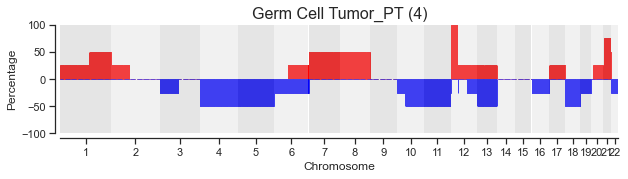

In [ ]:
with PdfPages(outdir+'/cnv_summary_by_datatype.1mb_pct.amp_del.'+time+'.pdf') as pdf:
    for ct in ct_select:
        for data_type in ['PDX','PT']:
            idx = pd.IndexSlice
            if data_type == 'PDX':
                a = amp_pct.loc[:, idx[:,'PDX']]
                a.columns = a.columns.get_level_values(0)
                b = del_pct.loc[:, idx[:,'PDX']]
                b.columns = b.columns.get_level_values(0)
            elif data_type == 'PT':
                a = amp_pct.loc[:, idx[:,'PT']]
                a.columns = a.columns.get_level_values(0)
                b = del_pct.loc[:, idx[:,'PT']]
                b.columns = b.columns.get_level_values(0)
            amp = pd.concat([amp_pct[['X','Chr']], a[ct]], axis = 1)
            amp.columns = ['X','Chr',ct]
            dele = pd.concat([del_pct[['X','Chr']], b[ct]], axis = 1)
            dele.columns = ['X','Chr',ct]
            amp = amp[amp['Chr']!='X']
            dele = dele[dele['Chr']!='X']

            sns.set_style("white") 
            sns.set_context('notebook',font_scale = 1, rc = {'lines.linewidth':1}) 
            sns.set_style("ticks")
            plt.subplots(figsize=(10, 2))
            plt.bar(amp['X'], amp[ct], edgecolor='red')
            plt.bar(dele['X'], dele[ct], edgecolor='blue')

            plt.title(ct +'_' +data_type + ' ('+ str(num.loc[(ct, data_type)]['Sample']) + ')', fontdict = {'fontsize' : 16})
            plt.ylim([-100,100])
            plt.xlim([0,len(amp)])

            sns.despine(offset=5)
            plt.xlabel('Chromosome')
            plt.ylabel('Percentage')
            plt.xticks(chr_bin['mid'], list(chr_bin['Chr']))
            for i in range(len(chr_bin)):
                if i % 2 == 1:
                    plt.axvspan(chr_bin['st'].iloc[i], chr_bin['ed'].iloc[i] , facecolor='lightgrey', alpha=0.3, lw=0)
                else:
                    plt.axvspan(chr_bin['st'].iloc[i], chr_bin['ed'].iloc[i] , facecolor='darkgrey', alpha=0.3, lw=0)
            pdf.savefig(dpi = 600,bbox_inches='tight')